Total Return: -2.50%
Max Drawdown: -10.65%


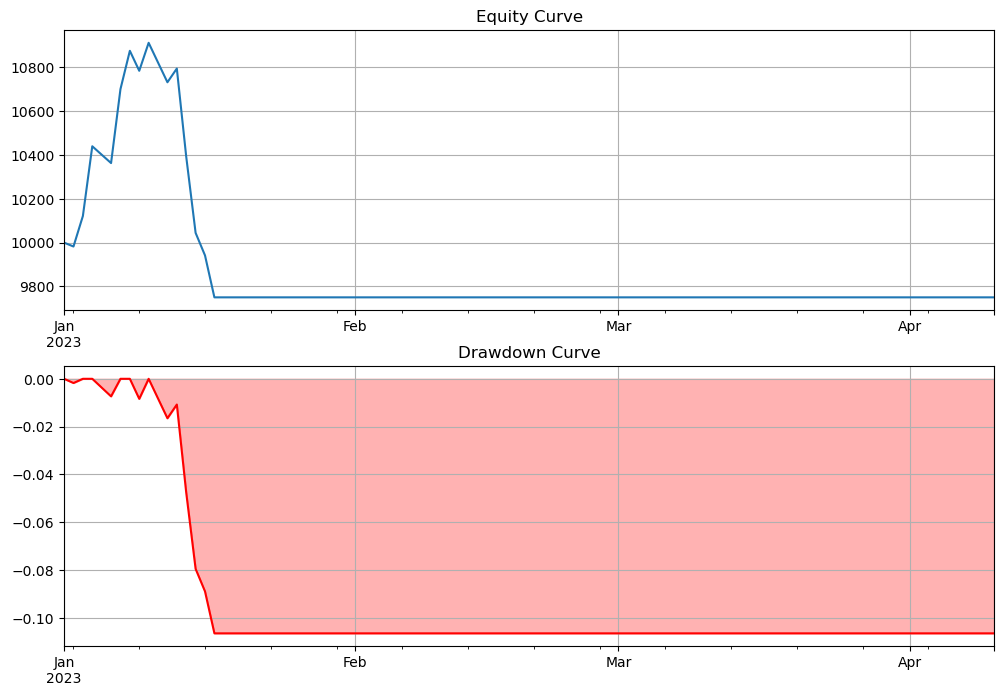

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_backtest(price_series, signal_series, initial_capital=10000):
    """
    計算策略績效
    
    Parameters:
    price_series (pd.Series): 資產價格
    signal_series (pd.Series): 交易訊號 (1=持有, 0=空手)，index 必須跟 price_series 對齊
    initial_capital (float): 初始本金
    
    Returns:
    dict: 包含 'equity_curve', 'max_drawdown', 'total_return' 等績效指標
    """
    
    # 1. 計算市場日報酬 (Market Returns)
    # 提示: 使用 pct_change()
    # market_returns = ...
    market_returns = price_series.pct_change()
    
    # 2. 處理未來函數 (Look-ahead Bias) - 最重要的一步！
    # 今天的訊號，只能用在「明天」的市場報酬上
    # 提示: 對 signal_series 做 shift()
    # signal_shifted = ...
    signal_shifted = signal_series.shift(1)
    
    # 3. 計算策略日報酬 (Strategy Returns)
    # 邏輯: 如果昨天持有 (1)，今天就獲得市場報酬；如果空手 (0)，報酬為 0
    # 提示: 兩個 Series 相乘 (Element-wise multiplication)
    # strategy_returns = ...
    strategy_returns = market_returns * signal_shifted
    
    # 4. 計算淨值曲線 (Equity Curve)
    # 邏輯: 從 1 開始，每天乘上 (1 + r)
    # 提示: 填補 NaN 為 0，然後使用 cumprod()。最後乘上 initial_capital。
    # equity_curve = (1 + strategy_returns.fillna(0)).cumprod() * ...
    equity_curve = (1 + strategy_returns.fillna(0)).cumprod() * initial_capital
    
    # 5. 計算最大回撤 (Max Drawdown) - 向量化挑戰
    # 定義: (當前淨值 - 至今為止的最高淨值) / 至今為止的最高淨值
    
    # TODO A: 算出「至今為止的最高淨值」 (Running Max)
    # 提示: 使用 cummax()
    # running_max = ...
    running_max = equity_curve.cummax()
    
    # TODO B: 算出回撤 (Drawdown)
    # drawdown = ...
    drawdown = (equity_curve - running_max) / running_max
    
    # TODO C: 找出「最大」回撤 (這會是一個負數，例如 -0.25)
    # max_dd = ...
    max_dd = drawdown.min()
    
    # 6. 整理輸出
    total_return = (equity_curve.iloc[-1] / initial_capital) - 1
    
    return {
        'equity_curve': equity_curve,
        'drawdown_curve': drawdown,
        'max_drawdown': max_dd,
        'total_return': total_return,
        'strategy_returns': strategy_returns # 方便之後算 Sharpe Ratio
    }

# --- 測試區 (Test Bench) ---
# 我們生成假數據來測試這個函數是否正確

# 造 100 天的假價格 (隨機漫步)
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=100)
returns = np.random.normal(0.001, 0.02, 100) # mean=0.1%, std=2%
prices = 100 * (1 + returns).cumprod()
price_series = pd.Series(prices, index=dates)

# 造一個簡單策略: 價格 > 100 就買，否則賣 (Mean Reversion)
signal_series = (price_series > 100).astype(int)

# 執行回測
results = run_backtest(price_series, signal_series)

# 檢查結果
print(f"Total Return: {results['total_return']:.2%}")
print(f"Max Drawdown: {results['max_drawdown']:.2%}")

# 畫圖驗證
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
results['equity_curve'].plot(title='Equity Curve')
plt.grid()

plt.subplot(2, 1, 2)
results['drawdown_curve'].plot(title='Drawdown Curve', color='red')
plt.fill_between(results['drawdown_curve'].index, results['drawdown_curve'], 0, color='red', alpha=0.3)
plt.grid()
plt.show()